# A Simple Industrial Example: Real-Time Bidding

Contrary to sponsored advertising, where advertisers set fixed bids, in real-time bid‐
ding (RTB) you can set a bid for every individual impression. When a user visits a
website that supports ads, this triggers an auction where advertisers bid for an impres‐
sion. Advertisers must submit bids within a period of time, where 100 ms is a com‐
mon limit.

The advertising platform provides contextual and behavioral information to the
advertiser for evaluation. The advertiser uses an automated algorithm to decide how
much to bid based upon the context. In the long-term, the platform’s products must
deliver a satisfying experience, to maintain the advertising revenue stream. But adver‐
tisers want to maximize some key performance indicator (KPI), for example, the
number of impressions or click through rate (CTR), for the least cost.

RTB presents a clear action (the bid), state (the information provided by the plat‐
form) and agent (the bidding algorithm). Both platforms and advertisers can use RL
to optimize for their definition of reward.

To quickly demonstrate this idea, below I present some code to simulate a bidding environment. First let me install the dependencies.

## A note on usage

Note that this notebook might not work on your machine because simple_rl forces TkAgg on some machines. See https://github.com/david-abel/simple_rl/issues/40

Also, Pygame is notoriously picky and expects loads of compiler/system related libraries.

I managed to get this working on the following notebook:

```
docker run -it -p 8888:8888 jupyter/scipy-notebook:54462805efcb
```

This code is untested on any other notebook.

TODO: migrate away from simple rl and pygame.
TODO: Create dedicated q-learning and sarsa notebooks.

In [1]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1 gym==0.17.3 gym-display-advertising==0.0.1 > /dev/null
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c > /dev/null
import matplotlib
matplotlib.use("agg", force=True)

  Running command git clone -q git://github.com/david-abel/simple_rl.git /tmp/pip-req-build-g820zz6v


## Global Defines

First is a small set of globals that set some of the options for the algorithms. Should be self explanatory.

In [2]:
eps = 0.05
gam = 0.99
alph = 0.0001
n_episodes = 200

## Helper Functions

This section contains quite a lot of code. These are the helper functions to perform various aspects of the problem. For example, I need to discretize the state space so that it works with the tabular value-based algorithms.

Then there is some helper code to perform the training iteration. Loops in loops.

In [3]:
import numpy as np

def state_mapping(obs):
    """
    Since this is tabular, we can't use real numbers. There would be an infinite
    number of states. Instead I round and convert to an integer. This is a
    simple form of _tile coding_.
    """
    return tuple(np.round(100 * obs[0:1]))

def run_episode(env, agent, learning=True):
    episode_reward = 0
    observation = env.reset()
    episode_over = False
    reward = 0
    action_buffer = []
    while not episode_over:
        if hasattr(agent, "q_func"):
            action = agent.act(
                state_mapping(observation),
                reward,
                learning=learning)
        else:
            action = agent.act(
                state_mapping(observation),
                reward)
        action_buffer.append(observation[0])
        observation, reward, episode_over, _ = env.step(action)
        episode_reward += reward
    agent.end_of_episode()
    return episode_reward, action_buffer

def train_agent(env, agent_func, n_repeats):
    train_rewards_buffer = np.zeros((n_episodes, n_repeats))
    train_bid_buffer = np.zeros((n_episodes, n_repeats, env.batch_size))
    for instance in range(n_repeats):
        agent = agent_func(range(env.action_space.n))
        for episode in range(n_episodes):
            episode_reward, action_buffer = run_episode(env, agent)
            train_rewards_buffer[episode, instance] = episode_reward
            train_bid_buffer[episode, instance, :] = np.pad(
                action_buffer, (0, env.batch_size - len(action_buffer)),
                'constant', constant_values=0)

    if hasattr(agent, "q_func"):
        print_arbitrary_policy(agent.q_func)

    # Test
    agent.epsilon = 0
    episode_reward, test_bid_buffer = run_episode(env, agent, learning=False)
    print(
        "{}: {}".format(
            "TEST",
            episode_reward))
    print(train_rewards_buffer.transpose())
    print(test_bid_buffer)
    return train_rewards_buffer, train_bid_buffer.mean(axis=2)

## Agents

Below I define the agents, again using `simple_rl`.

In [4]:
from simple_rl.agents import RandomAgent, DelayedQAgent, DoubleQAgent, QLearningAgent

def q_agent(actions):
    return QLearningAgent(
        actions,
        gamma=gam,
        epsilon=eps,
        alpha=alph,
    )

def random_agent(actions):
    return RandomAgent(actions)


def sarsa_agent(actions):
    return SARSAAgent(actions, 999, gamma=gam, epsilon=eps, alpha=alph, )

In [5]:
import pandas as pd

def average(data):
    return pd.DataFrame(data.mean(axis=1))

def save(df, path):
    df.to_json(path)

def print_arbitrary_policy(Q):
    for state in sorted(Q.keys(), key=lambda x: (x is None, x)):
        values = Q[state].items()
        print("{}: {}".format(state, sorted(values)))

## Running the Experiment

Finally I'm going to run the experiments. I also print a lot of debugging so you can see the raw Q-values. I encourage you to inspect these, and investigate how this changes through learning.

In [6]:
import gym
import gym_display_advertising

name = "bidding_rl_delta_q_learning"
env_name = "StaticDisplayAdvertising-v0"
num_repeats = 10
agent = q_agent
print("Starting {}".format(name))
env = gym.make(env_name)
rewards_buffer, bid_buffer = train_agent(env, agent, num_repeats)
save(average(rewards_buffer), name + ".json")
save(average(bid_buffer), name + "_bid.json")
print("Stopping {}".format(name))

Starting bidding_rl_delta_q_learning
(0.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(1.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]
(2.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 4.242504202164232e-23), (6, 0.0)]
(3.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 4.2933234764231805e-19)]
(4.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 1.772487965584318e-17)]
(5.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 1.7705427281303726e-14)]
(6.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 1.8529846316373888e-13), (6, 0.0)]
(7.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 1.0510479070676586e-09)]
(8.0,): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0), (4, 0), (5, 0.0), (6, 2.172726597811258e-09)]
(9.0,): [(0, 0.0), (1, 5.482986220213001e-14), (2, 0.0), (3, 0), (4, 0), (5, 0.0), (6, 0)]
(10.0,): [(0, 0.0), (1, 0), (2, 0.0

Next I run the same code again but this time with the random agent.

In [7]:
name = "bidding_rl_delta_random"
env_name = "StaticDisplayAdvertising-v0"
num_repeats = 10
agent = random_agent
print("Starting {}".format(name))
env = gym.make(env_name)
rewards_buffer, bid_buffer = train_agent(env, agent, num_repeats)
save(average(rewards_buffer), name + ".json")
save(average(bid_buffer), name + "_bid.json")
print("Stopping {}".format(name))

Starting bidding_rl_delta_random
TEST: 49
[[ 0.  0. 14. ...  9. 21.  1.]
 [ 0.  7. 11. ...  0.  0.  0.]
 [ 0. 13. 24. ... 14. 54.  0.]
 ...
 [27.  1.  9. ...  0.  0.  0.]
 [ 2.  0.  9. ...  3. 12.  4.]
 [24. 10.  0. ...  1.  0. 21.]]
[0.14806317863352023, 0.16286949649687227, 0.15472602167202865, 0.23208903250804297, 0.24369348413344513, 0.24369348413344513, 0.24369348413344513, 0.21932413572010062, 0.20835792893409558, 0.19794003248739078, 0.20783703411176035, 0.20783703411176035, 0.19744518240617231, 0.29616777360925844, 0.28135938492879553, 0.28135938492879553, 0.4220390773931933, 0.3798351696538739, 0.18991758482693696, 0.1804217055855901, 0.18944279086486962, 0.18944279086486962, 0.20838706995135658, 0.10419353497567829, 0.10940321172446221, 0.16410481758669332, 0.15589957670735866, 0.14030961903662278, 0.14732509998845392, 0.2209876499826809, 0.243086414980949, 0.23093209423190156, 0.24247869894349663, 0.2667265688378463, 0.4000898532567694, 0.3800853605939309, 0.3990896286236274

## Results

In the next two plots I present the sum of the rewards in an episode, over 200 episode, averaged over 10 runs. You'd need to perform more averaging to the the plots smoother.

You can see that the RL based agent quickly learns where to position the bid amount in order to maximize the reward.

The second image shows the bid amount changes over time.

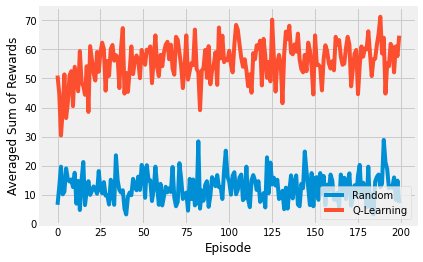

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

data_files = [("Random", "bidding_rl_delta_random.json"),
              ("Q-Learning", "bidding_rl_delta_q_learning.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

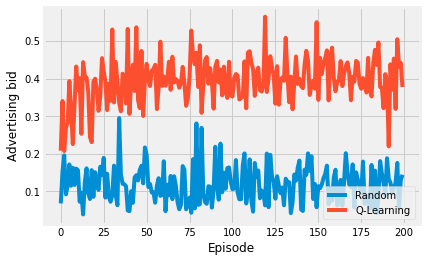

In [9]:
data_files = [("Random", "bidding_rl_delta_random_bid.json"),
              ("Q-Learning", "bidding_rl_delta_q_learning_bid.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Advertising bid')
ax.legend(loc='lower right')
plt.show()

## Further Work

In the book I also include an example with real data. You need to download and process an external repository to get that data, so it's a bit cumbersome to do here.

But the the general idea is that we want a better simulation of real bids. There's lots of advanced ways of building models, some of which I touch upon in other workshops, but a simple solution is to assume that the state isn't affected by your actions, then you can replay independent bid events and treat that as your simulation. Of course, this isn't great, since you could do the same thing with pure ML. But I hope that you can see that RL is a general framework for learning online.

TODO: In the future I will try and include some data in the package, which isn't working right now for some reason.